# Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data loading

In [4]:
data_folder = 'data/'
Go_ed = pd.read_csv(data_folder + 'Gowalla_edges.csv', sep="\t", names = ["id1","id2"])
Go_ch = pd.read_csv(data_folder + "Gowalla_totalCheckins.csv", sep="\t", names = ["user","time","latitude","longitude","location_id"])
Br_ed = pd.read_csv(data_folder + 'Brightkite_edges.csv', sep="\t", names = ["id1","id2"])
Br_ch = pd.read_csv(data_folder + "Brightkite_totalCheckins.csv", sep="\t", names = ["user","time","latitude","longitude","location_id"])

Let's see if it makes sense

In [3]:
Go_ed

,id1,id2
0,0,1
1,0,2
2,0,3
3,0,4
4,0,5
...,...,...
1900649,196586,196539
1900650,196587,196540
1900651,196588,196540
1900652,196589,196547


It seems that it's ok!!

# Data preparation

## Inference of the home of the users

### World partition

Considering 0.1 grades = 11.1km, the partition of the world into 25x25 km cells is:

In [4]:
side=25*0.1/11.1
Go_ch["cell"]=(Go_ch["latitude"]+90)//side + (Go_ch["longitude"]+180)//side*int(180/side)
Br_ch["cell"]=(Br_ch["latitude"]+90)//side + (Br_ch["longitude"]+180)//side*int(180/side)

### Data cleaning

In [5]:
Br_ch.sort_values(by = "latitude", ascending = False).head(15)

,user,time,latitude,longitude,location_id,cell
3231786,14201,2009-01-18T02:29:34Z,151.198000,-33.878333,884499bae3cb11ddbae9003048c0801e,518822.0
3231781,14201,2009-01-19T07:34:58Z,151.198000,-33.878333,884499bae3cb11ddbae9003048c0801e,518822.0
3231782,14201,2009-01-18T23:56:08Z,151.198000,-33.878333,884499bae3cb11ddbae9003048c0801e,518822.0
3231783,14201,2009-01-18T12:24:39Z,151.198000,-33.878333,884499bae3cb11ddbae9003048c0801e,518822.0
3231784,14201,2009-01-18T10:32:33Z,151.198000,-33.878333,884499bae3cb11ddbae9003048c0801e,518822.0
3231785,14201,2009-01-18T04:05:27Z,151.198000,-33.878333,884499bae3cb11ddbae9003048c0801e,518822.0
3231787,14201,2009-01-16T13:45:22Z,151.198000,-33.878333,884499bae3cb11ddbae9003048c0801e,518822.0
3231788,14201,2009-01-16T13:45:20Z,151.198000,-33.878333,884499bae3cb11ddbae9003048c0801e,518822.0
3231789,14201,2009-01-15T23:04:57Z,151.092167,-33.870000,8d522300e25911dda5f6003048c10834,518822.0
3231793,14201,2009-01-14T17:36:55Z,151.092167,-33.870000,8d522300e25911dda5f6003048c10834,518822.0


Oh noo!!! It seems to be values of latitude (and longitude) that do not make sense. Range(latitude) = [-90,90] & Range(longitude) = [-180,180].
Let's drop them:

In [6]:
Go_ch = Go_ch.drop(Go_ch[Go_ch.latitude<-90].index)
Go_ch = Go_ch.drop(Go_ch[Go_ch.latitude>90].index)
Go_ch = Go_ch.drop(Go_ch[Go_ch.longitude<-180].index)
Go_ch = Go_ch.drop(Go_ch[Go_ch.longitude>180].index)
Br_ch = Br_ch.drop(Br_ch[Br_ch.latitude<-90].index)
Br_ch = Br_ch.drop(Br_ch[Br_ch.latitude>90].index)
Br_ch = Br_ch.drop(Br_ch[Br_ch.longitude<-180].index)
Br_ch = Br_ch.drop(Br_ch[Br_ch.longitude>180].index)

### Mean latitude and longitude of the most common cell of each user

In [7]:
#FIRST, THE NUMBER OF TIMES A CHECK-IN HAPPENS IN A CELL FOR EACH USER IS COUNTED
Go_ch_cell_count = Go_ch.groupby(["user","cell"]).count().reset_index()[["user","cell","time"]].rename(columns = {"time":"cell_count"})
#THEN, FOR EACH USER THE NUMBER OF CHECK-INS OF THE MOST COMMON CELL IS OBTAINED
Go_ch_cell_max = Go_ch_cell_count.groupby("user")["cell_count"].max().reset_index().rename(columns={"cell_count":"cell_max"})
#FINALLY, FOR EVERY USER IN EACH CELL, THE MEAN OF THE LONGITUDE AND LATITUDE IS CALCULATED
Go_ch_cell_mean = Go_ch.groupby(["user","cell"])["latitude","longitude"].agg("mean").reset_index().rename(columns = {"latitude":"latitude_mean","longitude":"longitude_mean"})

## SAME   FOR   OTHER   DATASET
Br_ch_cell_count = Br_ch.groupby(["user","cell"]).count().reset_index()[["user","cell","time"]].rename(columns = {"time":"cell_count"})
Br_ch_cell_max = Br_ch_cell_count.groupby("user")["cell_count"].max().reset_index().rename(columns={"cell_count":"cell_max"})
Br_ch_cell_mean = Br_ch.groupby(["user","cell"])["latitude","longitude"].agg("mean").reset_index().rename(columns = {"latitude":"latitude_mean","longitude":"longitude_mean"})

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  
C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  # This is added back by InteractiveShellApp.init_path()


In [8]:
print(Go_ch_cell_count)
print(Go_ch_cell_max)
print(Go_ch_cell_mean)

          user      cell  cell_count
0            0  204311.0           3
1            0  204312.0          20
2            0  205109.0           2
3            0  205110.0           1
4            0  259449.0           6
...        ...       ...         ...
674591  196578  636633.0          15
674592  196578  637432.0           9
674593  196578  638231.0           1
674594  196585  669385.0           1
674595  196585  670183.0           1

[674596 rows x 3 columns]
          user  cell_max
0            0       119
1            1         1
2            2       750
3            4       204
4            5        30
...        ...       ...
107087  196544         1
107088  196561       124
107089  196577         3
107090  196578        15
107091  196585         1

[107092 rows x 2 columns]
          user      cell  latitude_mean  longitude_mean
0            0  204311.0      37.616356     -122.386150
1            0  204312.0      37.780813     -122.406536
2            0  205109.0      37.4

In [9]:
#THE MEAN VALUES OF THE CHECK-INS FOR EACH CELL&USER IS MERGED WITH THE NUMBER OF CHECK-INS OF EACH CELL AND WITH THE MAXIMUM OF CHECK-INS PER CELL&USER
Go_home = Go_ch_cell_mean.merge(Go_ch_cell_count).merge(Go_ch_cell_max)
##THE CELLS IN WHICH THE NUMBER OF CHECK-INS MATCH THE NUMBER OF CHEK-INS OF THE MOST COMMON CELL FOR EACH USER STAY. THE OTHER ARE NOT USED
Go_home = Go_home[(Go_home["cell_max"] == Go_home["cell_count"])][["user","latitude_mean","longitude_mean"]]
##FOR THAT USERS THAT HAVE MULTIPLE CELLS WITH THE SAME NUMBER OF CHECK-INS (BEING THE MOST COMMON) THE VALUES ARE MEANED
Go_home = Go_home.groupby("user").mean()

## SAME   FOR   OTHER   DATASET
Br_home = Br_ch_cell_mean.merge(Br_ch_cell_count).merge(Br_ch_cell_max)
Br_home = Br_home[(Br_home["cell_max"] == Br_home["cell_count"])][["user","latitude_mean","longitude_mean"]]
Br_home = Br_home.groupby("user").mean()

In [10]:
Go_home

,latitude_mean,longitude_mean
user,,
0,30.258624,-97.748824
1,47.204338,4.499703
2,37.839812,-122.252373
4,37.778756,-122.437161
5,30.294812,-97.730042
...,...,...
196544,-25.433409,-49.281533
196561,37.529416,-122.005527
196577,51.529196,0.062099


Notice that in this DataFrame the index is the user.

## Let's calculate the distances between each edge

### Problem: some users do not have home

In [11]:
##THE USER WHICH HAVE AT LEAST ONCE CHECKED-IN ARE STORED FOR BOTH DATASETS
Go_users = Go_ch_cell_count["user"].drop_duplicates()
Br_users = Br_ch_cell_count["user"].drop_duplicates()
##THE EDGES WHOSE USERS HAVE NEVER CHECKED-IN ARE DROPPED FOR BOTH DATASETS
Go_ed = Go_ed[Go_ed["id1"].isin(Go_users)]
Go_ed = Go_ed[Go_ed["id2"].isin(Go_users)]
Br_ed = Br_ed[Br_ed["id1"].isin(Br_users)]
Br_ed = Br_ed[Br_ed["id2"].isin(Br_users)]

In [12]:
Go_ed

,id1,id2
0,0,1
1,0,2
3,0,4
4,0,5
6,0,7
...,...,...
1900533,196508,196109
1900540,196512,196160
1900541,196513,196160
1900549,196520,4727


In [13]:
#FIRST THE LATITUDE AND LONGITUDE OF THE FIRST USER IS OBTAINED SETTING THIS USER AS THE INDEX AND USING THE "Go_home" DATA FRAME
Go_ed = Go_ed.set_index("id1")
Go_ed["id1_lat"] = Go_home["lat"]
Go_ed["id1_lon"] = Go_home["long"]
#THEN THE PROCESS IS REPEATED FOR THE SECOND USER
Go_ed = Go_ed.reset_index().set_index("id2")
Go_ed["id2_lat"] = Go_home["lat"]
Go_ed["id2_lon"] = Go_home["long"]
#FINALLY THE INDEX IS RESETED SO THAT ALL INFORMATION IS EQUALLY ACCESIBLE
Go_ed = Go_ed.reset_index()

#SAME FOR BRIGHTKITE DATASET
Br_ed = Br_ed.set_index("id1")
Br_ed["id1_lat"] = Br_home["lat"]
Br_ed["id1_lon"] = Br_home["long"]
Br_ed = Br_ed.reset_index().set_index("id2")
Br_ed["id2_lat"] = Br_home["lat"]
Br_ed["id2_lon"] = Br_home["long"]
Br_ed = Br_ed.reset_index()

In [14]:
Go_ed

,id2,id1,id1_lat,id1_lon,id2_lat,id2_lon
0,1,0,30.258624,-97.748824,47.204338,4.499703
1,2,0,30.258624,-97.748824,37.839812,-122.252373
2,4,0,30.258624,-97.748824,37.778756,-122.437161
3,5,0,30.258624,-97.748824,30.294812,-97.730042
4,7,0,30.258624,-97.748824,30.264583,-97.744253
...,...,...,...,...,...,...
913655,196109,196508,51.769524,-0.572672,37.316198,-121.988518
913656,196160,196512,30.192386,-81.565471,30.237752,-81.538301
913657,196160,196513,30.136064,-81.534063,30.237752,-81.538301
913658,4727,196520,52.353922,4.880389,52.358856,4.897302


Source: https://stackoverflow.com/questions/1253499/simple-calculations-for-working-with-lat-lon-and-km-distance

from haversine import haversine

Go_ed["distance_haversine"] = haversine((Go_ed["id1_lat"],Go_ed["id1_lon"]),(Go_ed["id2_lat"],Go_ed["id2_lon"]))

const R = 6371e3; // metres
const φ1 = lat1 * Math.PI/180; // φ, λ in radians
const φ2 = lat2 * Math.PI/180;
const Δφ = (lat2-lat1) * Math.PI/180;
const Δλ = (lon2-lon1) * Math.PI/180;

const a = Math.sin(Δφ/2) * Math.sin(Δφ/2) +
          Math.cos(φ1) * Math.cos(φ2) *
          Math.sin(Δλ/2) * Math.sin(Δλ/2);
const c = 2 * Math.atan2(Math.sqrt(a), Math.sqrt(1-a));

const d = R * c; // in metres

In [15]:
# approximate radius of earth in km
R = 6373.0

Go_ed["id1_lat"] = np.radians(Go_ed["id1_lat"])
Go_ed["id2_lat"] = np.radians(Go_ed["id2_lat"])
Go_ed["id1_lon"] = np.radians(Go_ed["id1_lon"])
Go_ed["id2_lon"] = np.radians(Go_ed["id2_lon"])

Go_ed["lat_dis"] = Go_ed["id2_lat"]-Go_ed["id1_lat"]
Go_ed["lon_dis"] = Go_ed["id2_lon"]-Go_ed["id1_lon"]



Go_ed["a"] = np.sin(Go_ed["lat_dis"] / 2)**2 + np.cos(Go_ed["id1_lat"]) * np.cos(Go_ed["id2_lat"]) * np.sin(Go_ed["lon_dis"] / 2)**2
Go_ed["c"] = 2 * np.arctan2(np.sqrt(Go_ed["a"]), np.sqrt(1 - Go_ed["a"]))

Go_ed["distance"] = R * Go_ed["c"]


Br_ed["id1_lat"] = np.radians(Br_ed["id1_lat"])
Br_ed["id2_lat"] = np.radians(Br_ed["id2_lat"])
Br_ed["id1_lon"] = np.radians(Br_ed["id1_lon"])
Br_ed["id2_lon"] = np.radians(Br_ed["id2_lon"])

Br_ed["lat_dis"] = Br_ed["id2_lat"]-Br_ed["id1_lat"]
Br_ed["lon_dis"] = Br_ed["id2_lon"]-Br_ed["id1_lon"]



Br_ed["a"] = np.sin(Br_ed["lat_dis"] / 2)**2 + np.cos(Br_ed["id1_lat"]) * np.cos(Br_ed["id2_lat"]) * np.sin(Br_ed["lon_dis"] / 2)**2
Br_ed["c"] = 2 * np.arctan2(np.sqrt(Br_ed["a"]), np.sqrt(1 - Br_ed["a"]))

Br_ed["distance"] = R * Br_ed["c"]

In [59]:
Go_ed = Go_ed[["id1","id2","distance"]]
Go_ed

,id1,id2,distance
0,0,1,8431.541404
1,0,2,2401.763751
2,0,4,2416.048866
3,0,5,4.411039
4,0,7,0.795119
...,...,...,...
663799,58226,1903,3168.304463
663800,58226,5566,3333.734354
663801,58227,1903,5.223921
663802,58227,1930,1998.593373


#FIRST THE DISTANCE BETWEEN THE LATITUDES FOR EACH EDGE IS OBTAINED
Go_ed["lat_dis"] = abs(Go_ed["id1_lat"]-Go_ed["id2_lat"])*110.574
#THEN THE DISTANCE BETWEEN THE LONGITUDES FOR EACH EDGE IS OBTAINED
Go_ed["lon_dis"] = abs((Go_ed["id1_lon"]-Go_ed["id2_lon"])*np.cos((Go_ed["id1_lat"]+Go_ed["id2_lat"])/2))*111.320
#FINALLY THE TOTAL DISTANCE IS CALCULATED
Go_ed["distance"] = np.sqrt(Go_ed["lat_dis"]**2+Go_ed["lon_dis"]**2)

#SAME FOR BRIGHTKITE DATASET
Br_ed["lat_dis"] = abs(Br_ed["id1_lat"]-Br_ed["id2_lat"])*110.574
Br_ed["lon_dis"] = abs((Br_ed["id1_lon"]-Br_ed["id2_lon"])*np.cos((Br_ed["id1_lat"]+Br_ed["id2_lat"])/2))*111.320
Br_ed["distance"] = np.sqrt(Br_ed["lat_dis"]**2+Br_ed["lon_dis"]**2)

Go_ed

In [17]:
#THE ONLY CRUCIAL INFO IS THE DISTANCE
Go_ed = Go_ed[["id1","id2","distance"]]
Br_ed = Br_ed[["id1","id2","distance"]]

In [18]:
print(Go_ed,Br_ed)

           id1     id2     distance
0            0       1  8431.541404
1            0       2  2401.763751
2            0       4  2416.048866
3            0       5     4.411039
4            0       7     0.795119
...        ...     ...          ...
913655  196508  196109  8599.254377
913656  196512  196160     5.681807
913657  196513  196160    11.318118
913658  196520    4727     1.273335
913659  196531  196283     2.636807

[913660 rows x 3 columns]           id1    id2     distance
0           0      1  1528.509480
1           0      2     1.136335
2           0      3  1527.531139
3           0      4  8005.414925
4           0      5  1527.510434
...       ...    ...          ...
394329  58225  58226     0.000000
394330  58225  58227     0.000000
394331  58226  58220    23.753912
394332  58226  58225     0.000000
394333  58227  58225     0.000000

[394334 rows x 3 columns]


## Probability

In [19]:
print(Go_ed["distance"].max(),Br_ed["distance"].max())

19971.19368492079 19432.465288806205


In [29]:
Go_ed["distance"].max()

19971.19368492079

As we can see in the above cell the maximum distance between users in both Datasets is approximately 35000km

In [30]:
#SPLITTIG THE DIFFERENT DISTANCES INTO BINS LOGARITHMICALLY SPACED
bins = np.logspace(-1,np.log10(20000),70)
#CREATION OF A HELPING DATAFRAME WITH THE ABSOLUTE ERROR BETWEEN THE DISTANCES AND THE OPTIONS IN BINS
Go_help = pd.DataFrame()
Br_help = pd.DataFrame()
for i in range(len(bins)):
    Go_help[i] = (abs(Go_ed["distance"]-bins[i]))
    Br_help[i] = (abs(Br_ed["distance"]-bins[i]))

In [31]:
Go_help

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,8431.441404,8431.422053,8431.398958,8431.371392,8431.338493,8431.299228,8431.252364,8431.196431,8431.129675,8431.050000,...,4361.570537,3573.985335,2633.993526,1512.102714,173.113395,1424.985438,3332.334394,5608.776856,8325.736573,11568.458596
1,2401.663751,2401.644400,2401.621304,2401.593739,2401.560840,2401.521574,2401.474711,2401.418778,2401.352022,2401.272347,...,1668.207116,2455.792318,3395.784127,4517.674939,5856.664258,7454.763091,9362.112047,11638.554509,14355.514226,17598.236249
2,2415.948866,2415.929515,2415.906419,2415.878854,2415.845955,2415.806689,2415.759825,2415.703893,2415.637136,2415.557462,...,1653.922001,2441.507204,3381.499013,4503.389824,5842.379143,7440.477976,9347.826933,11624.269394,14341.229111,17583.951134
3,4.311039,4.291688,4.268592,4.241027,4.208128,4.168862,4.121998,4.066066,3.999309,3.919635,...,4065.559828,4853.145030,5793.136840,6915.027651,8254.016970,9852.115803,11759.464759,14035.907221,16752.866938,19995.588961
4,0.695119,0.675768,0.652672,0.625107,0.592208,0.552942,0.506078,0.450145,0.383389,0.303715,...,4069.175748,4856.760951,5796.752760,6918.643571,8257.632890,9855.731723,11763.080680,14039.523141,16756.482858,19999.204881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
913655,8599.154377,8599.135026,8599.111930,8599.084365,8599.051465,8599.012200,8598.965336,8598.909403,8598.842647,8598.762973,...,4529.283509,3741.698307,2801.706498,1679.815686,340.826367,1257.272466,3164.621422,5441.063883,8158.023600,11400.745623
913656,5.581807,5.562456,5.539360,5.511795,5.478896,5.439630,5.392766,5.336834,5.270077,5.190403,...,4064.289060,4851.874263,5791.866072,6913.756883,8252.746202,9850.845035,11758.193992,14034.636453,16751.596170,19994.318193
913657,11.218118,11.198767,11.175671,11.148106,11.115207,11.075941,11.029077,10.973144,10.906388,10.826714,...,4058.652749,4846.237952,5786.229761,6908.120572,8247.109891,9845.208724,11752.557681,14029.000142,16745.959859,19988.681882
913658,1.173335,1.153984,1.130888,1.103323,1.070424,1.031158,0.984294,0.928362,0.861605,0.781931,...,4068.697532,4856.282734,5796.274544,6918.165355,8257.154674,9855.253507,11762.602463,14039.044925,16756.004642,19998.726665


In [32]:
#SIZE OF EACH BIN
rang = np.empty(len(bins))
for i in range(len(bins)-1):
    rang[i] = bins[i+1]-bins[i]
rang[0:-1] #LAST ELEMENT MAKES NO SENSE

array([1.93511263e-02, 2.30957872e-02, 2.75650821e-02, 3.28992360e-02,
       3.92656087e-02, 4.68639462e-02, 5.59326476e-02, 6.67562448e-02,
       7.96743301e-02, 9.50922103e-02, 1.13493624e-01, 1.35455919e-01,
       1.61668164e-01, 1.92952775e-01, 2.30291310e-01, 2.74855272e-01,
       3.28042863e-01, 3.91522852e-01, 4.67286934e-01, 5.57712218e-01,
       6.65635814e-01, 7.94443841e-01, 9.48177672e-01, 1.13166073e+00,
       1.35064983e+00, 1.61201578e+00, 1.92395899e+00, 2.29626672e+00,
       2.74062020e+00, 3.27096107e+00, 3.90392888e+00, 4.65938309e+00,
       5.56102619e+00, 6.63714740e+00, 7.92151017e+00, 9.45441161e+00,
       1.12839467e+01, 1.34675175e+01, 1.60736338e+01, 1.91840630e+01,
       2.28963953e+01, 2.73271056e+01, 3.26152084e+01, 3.89266185e+01,
       4.64593576e+01, 5.54497666e+01, 6.61799210e+01, 7.89864811e+01,
       9.42712547e+01, 1.12513804e+02, 1.34286493e+02, 1.60272441e+02,
       1.91286964e+02, 2.28303146e+02, 2.72482376e+02, 3.25210785e+02,
      

In [33]:
#APPROXIMATION OF THE DISTANCES USING THE BINS
Go_ed["distance_approx"] = bins[Go_help.idxmin(axis=1)]
Br_ed["distance_approx"] = bins[Br_help.idxmin(axis=1)]

C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [34]:
Go_ed

,id1,id2,distance,distance_approx
0,0,1,8431.541404,8258.428009
1,0,2,2401.763751,2393.931589
2,0,4,2416.048866,2393.931589
3,0,5,4.411039,4.105414
4,0,7,0.795119,0.835446
...,...,...,...,...
913655,196508,196109,8599.254377,8258.428009
913656,196512,196160,5.681807,5.848035
913657,196513,196160,11.318118,11.866321
913658,196520,4727,1.273335,1.190067


In [35]:
#CREATION OF A DATAFRAME COUNTING THE NUMBER OF CHECK-INS FOR EACH BIN
Go_plot = pd.DataFrame(Go_ed.groupby("distance_approx")["distance"].count()).rename(columns = {"distance":"count"})
Br_plot = pd.DataFrame(Br_ed.groupby("distance_approx")["distance"].count()).rename(columns = {"distance":"count"})

In [36]:
#ADD THE SIZE OF THE BIN TO THE DATAFRAME
Go_plot["rang"]=rang
Br_plot["rang"]=rang

In [37]:
Go_plot

,count,rang
distance_approx,,
0.100000,2564,1.935113e-02
0.119351,832,2.309579e-02
0.142447,1168,2.756508e-02
0.170012,1472,3.289924e-02
0.202911,2050,3.926561e-02
...,...,...
9856.526842,12070,1.907349e+03
11763.875799,9876,2.276442e+03
14040.318260,9206,2.716960e+03


In [38]:
#CALCULATION OF THE PROBABILITY CONSIDERING THE SIZE OF THE BIN AND THE NUMBER OF EDGES
Go_plot["probability"]=Go_plot["count"]/Go_plot["rang"]/len(Go_ed)
Br_plot["probability"]=Br_plot["count"]/Br_plot["rang"]/len(Br_ed)

# Data Visualization

Text(0, 0.5, 'Probability')

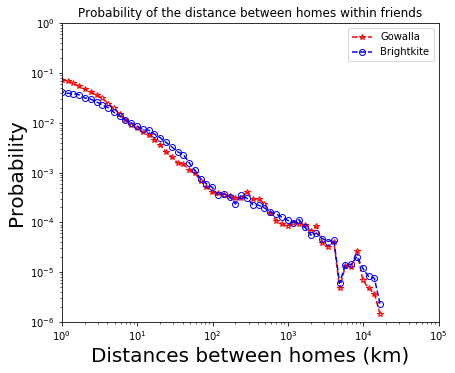

In [39]:
#MATCHING THE PROPORTION OF THE AXES WITH THE REFERENCE PLOT
plt.figure(figsize=(6.75,5.5))
#MATCHING THE AXES LIMITS WITH THE REFERENCE PLOT
plt.ylim((10**-6, 10**0))
plt.xlim((10**0, 10**5))
#PLOTTING THE PROBABILITY FOR EACH SOCIAL NETWORK
plt.loglog(Go_plot["probability"], "r*--",  Br_plot["probability"], "bo--", fillstyle = "none", label="Gowalla")
#ADDING LEGEND, TITLE AND AXIS LABELS
plt.legend(["Gowalla","Brightkite"])
plt.title("Probability of the distance between homes within friends")
plt.xlabel("Distances between homes (km)", fontsize=20)
plt.ylabel("Probability", fontsize=20)

The similarity between plots from my point of view is about 80-90%. (This was asked in the Google form)
<br>The main difference I see is in the valley in about 4000km which is not that deep.

# P4

In [28]:
Go_nat = pd.read_csv("data/Go_nat.csv")

In [29]:
data_folder = 'data/'
Go_ed = pd.read_csv(data_folder + 'Gowalla_edges.csv', sep="\t", names = ["id1","id2"])
Go_ch = pd.read_csv(data_folder + "Gowalla_totalCheckins.csv", sep="\t", names = ["user","time","latitude","longitude","location_id"])
Br_ed = pd.read_csv(data_folder + 'Brightkite_edges.csv', sep="\t", names = ["id1","id2"])
Br_ch = pd.read_csv(data_folder + "Brightkite_totalCheckins.csv", sep="\t", names = ["user","time","latitude","longitude","location_id"])

In [30]:
Go_home = pd.read_csv("data/Go_home.csv")
Br_home = pd.read_csv("data/Br_home.csv")

In [31]:
#FIRST THE LATITUDE AND LONGITUDE OF THE FIRST USER IS OBTAINED SETTING THIS USER AS THE INDEX AND USING THE "Go_home" DATA FRAME
Go_ed = Go_ed.set_index("id1")
Go_ed["id1_lat"] = Go_home["lat"]
Go_ed["id1_lon"] = Go_home["long"]
#THEN THE PROCESS IS REPEATED FOR THE SECOND USER
Go_ed = Go_ed.reset_index().set_index("id2")
Go_ed["id2_lat"] = Go_home["lat"]
Go_ed["id2_lon"] = Go_home["long"]
#FINALLY THE INDEX IS RESETED SO THAT ALL INFORMATION IS EQUALLY ACCESIBLE
Go_ed = Go_ed.reset_index()

#SAME FOR BRIGHTKITE DATASET
Br_ed = Br_ed.set_index("id1")
Br_ed["id1_lat"] = Br_home["lat"]
Br_ed["id1_lon"] = Br_home["long"]
Br_ed = Br_ed.reset_index().set_index("id2")
Br_ed["id2_lat"] = Br_home["lat"]
Br_ed["id2_lon"] = Br_home["long"]
Br_ed = Br_ed.reset_index()

In [32]:
# approximate radius of earth in km
R = 6373.0

Go_ed["id1_lat"] = np.radians(Go_ed["id1_lat"])
Go_ed["id2_lat"] = np.radians(Go_ed["id2_lat"])
Go_ed["id1_lon"] = np.radians(Go_ed["id1_lon"])
Go_ed["id2_lon"] = np.radians(Go_ed["id2_lon"])

Go_ed["lat_dis"] = Go_ed["id2_lat"]-Go_ed["id1_lat"]
Go_ed["lon_dis"] = Go_ed["id2_lon"]-Go_ed["id1_lon"]



Go_ed["a"] = np.sin(Go_ed["lat_dis"] / 2)**2 + np.cos(Go_ed["id1_lat"]) * np.cos(Go_ed["id2_lat"]) * np.sin(Go_ed["lon_dis"] / 2)**2
Go_ed["c"] = 2 * np.arctan2(np.sqrt(Go_ed["a"]), np.sqrt(1 - Go_ed["a"]))

Go_ed["distance"] = R * Go_ed["c"]


Br_ed["id1_lat"] = np.radians(Br_ed["id1_lat"])
Br_ed["id2_lat"] = np.radians(Br_ed["id2_lat"])
Br_ed["id1_lon"] = np.radians(Br_ed["id1_lon"])
Br_ed["id2_lon"] = np.radians(Br_ed["id2_lon"])

Br_ed["lat_dis"] = Br_ed["id2_lat"]-Br_ed["id1_lat"]
Br_ed["lon_dis"] = Br_ed["id2_lon"]-Br_ed["id1_lon"]



Br_ed["a"] = np.sin(Br_ed["lat_dis"] / 2)**2 + np.cos(Br_ed["id1_lat"]) * np.cos(Br_ed["id2_lat"]) * np.sin(Br_ed["lon_dis"] / 2)**2
Br_ed["c"] = 2 * np.arctan2(np.sqrt(Br_ed["a"]), np.sqrt(1 - Br_ed["a"]))

Br_ed["distance"] = R * Br_ed["c"]

In [33]:
Go_ed = Go_ed.set_index("id1")
Go_ed["id1_nat"] = Go_nat.set_index("user")["country"]
Go_ed = Go_ed.reset_index().set_index("id2")
Go_ed["id2_nat"] = Go_nat.set_index("user")["country"]
Go_ed = Go_ed.reset_index()

In [34]:
Go_ed = Go_ed.dropna()

In [35]:
Go_ed

,id2,id1,id1_lat,id1_lon,id2_lat,id2_lon,lat_dis,lon_dis,a,c,distance,id1_nat,id2_nat
0,1,0,0.693924,-1.832188,0.655913,-2.135447,-0.038011,-0.303259,1.426102e-02,0.239410,1525.762163,United States,United States
1,2,0,0.693924,-1.832188,0.694114,-1.832549,0.000189,-0.000361,2.818694e-08,0.000336,2.139922,United States,United States
2,3,0,0.693924,-1.832188,0.659056,-2.136925,-0.034868,-0.304737,1.430459e-02,0.239778,1528.102532,United States,United States
3,4,0,0.693924,-1.832188,1.050238,0.435357,0.356313,2.267545,3.452588e-01,1.256148,8005.428584,United States,Finland
4,5,0,0.693924,-1.832188,0.658997,-2.136695,-0.034927,-0.304507,1.428528e-02,0.239615,1527.065754,United States,United States
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1148509,38759,50685,0.590503,0.625410,0.831026,-2.135250,0.240523,-2.760660,5.542873e-01,1.679585,10703.997489,United States,United States
1148513,48568,50685,0.590503,0.625410,0.633591,2.405940,0.043088,1.780530,4.048697e-01,1.379369,8790.716427,United States,United States
1148514,50514,50685,0.590503,0.625410,0.844877,-1.243725,0.254374,-1.869135,3.728343e-01,1.313640,8371.828451,United States,United States
1148515,50520,50685,0.590503,0.625410,0.898737,-0.003980,0.308234,-0.629390,7.311272e-02,0.547604,3489.878838,United States,United States


In [36]:
Go_friends_ch = pd.DataFrame(Go_ed.groupby("id1")["id2"].count()).rename(columns={"id2":"n_friends"})

In [37]:
Go_friends_ch["n_friends_same_country"] = Go_ed[Go_ed.id1_nat == Go_ed.id2_nat].groupby("id1")["id2"].count()

In [38]:
Go_friends_ch

,n_friends,n_friends_same_country
id1,,
0,564,487.0
1,775,669.0
2,1295,1093.0
3,1460,1065.0
4,31,NaN
...,...,...
50680,12,11.0
50681,11,7.0
50682,6,4.0


In [39]:
Go_friends_ch["ratio_friends_same_country"] = Go_friends_ch["n_friends_same_country"]/Go_friends_ch["n_friends"]

In [40]:
Go_friends_ch

,n_friends,n_friends_same_country,ratio_friends_same_country
id1,,,
0,564,487.0,0.863475
1,775,669.0,0.863226
2,1295,1093.0,0.844015
3,1460,1065.0,0.729452
4,31,NaN,NaN
...,...,...,...
50680,12,11.0,0.916667
50681,11,7.0,0.636364
50682,6,4.0,0.666667


In [41]:
threshold = 50

In [42]:
Go_friends_ch["n_friends_near"] = Go_ed[Go_ed.distance < threshold].groupby("id1")["id2"].count()

In [43]:
Go_friends_ch = Go_friends_ch.fillna(0)

In [44]:
Go_friends_ch["ratio_friends_near"] = Go_friends_ch["n_friends_near"]/Go_friends_ch["n_friends"]

In [45]:
Go_friends_ch

,n_friends,n_friends_same_country,ratio_friends_same_country,n_friends_near,ratio_friends_near
id1,,,,,
0,564,487.0,0.863475,98.0,0.173759
1,775,669.0,0.863226,104.0,0.134194
2,1295,1093.0,0.844015,185.0,0.142857
3,1460,1065.0,0.729452,77.0,0.052740
4,31,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...
50680,12,11.0,0.916667,0.0,0.000000
50681,11,7.0,0.636364,0.0,0.000000
50682,6,4.0,0.666667,0.0,0.000000


In [46]:
Go_ed[Go_ed.id1 == 4]

,id2,id1,id1_lat,id1_lon,id2_lat,id2_lon,lat_dis,lon_dis,a,c,distance,id1_nat,id2_nat
4336,0,4,1.050238,0.435357,0.693924,-1.832188,-0.356313,-2.267545,0.345259,1.256148,8005.428584,Finland,United States
4337,154,4,1.050238,0.435357,0.680095,-1.662569,-0.370142,-2.097925,0.324483,1.212122,7724.852041,Finland,United Kingdom
4338,191,4,1.050238,0.435357,0.695277,-1.833186,-0.354961,-2.268543,0.344816,1.255217,7999.495133,Finland,Japan
4339,234,4,1.050238,0.435357,0.456779,-1.398661,-0.593459,-1.834018,0.366753,1.301043,8291.544268,Finland,United States
4340,235,4,1.050238,0.435357,0.742167,-1.246597,-0.308070,-1.681953,0.227151,0.993575,6332.051607,Finland,United States
4341,267,4,1.050238,0.435357,0.659357,-2.136340,-0.390880,-2.571697,0.399759,1.368947,8724.298769,Finland,United Kingdom
4342,347,4,1.050238,0.435357,0.659682,-2.136752,-0.390556,-2.572109,0.399650,1.368724,8722.876039,Finland,United States
4344,464,4,1.050238,0.435357,0.659297,-2.136622,-0.390941,-2.571978,0.399818,1.369066,8725.057056,Finland,United States
4345,557,4,1.050238,0.435357,0.729154,-1.222271,-0.321083,-1.657627,0.227088,0.993424,6331.088321,Finland,United States
4346,3527,4,1.050238,0.435357,0.627633,-1.464702,-0.422605,-1.900059,0.310362,1.181784,7531.506533,Finland,Netherlands
